# Getting started

In this notebook, we use `TorchSurv` to train a model that predicts relative risk of breast cancer recurrence. We use a public data set, the [German Breast Cancer Study Group 2 (GBSG2)](https://paperswithcode.com/dataset/gbsg2). After training the model, we evaluate the predictive performance using evaluation metrics implemented in `TorchSurv`.


We first load the dataset using the package [lifelines](https://lifelines.readthedocs.io/en/latest/). The GBSG2 dataset contains features and recurrence free survival time (in days) for 686 women undergoing hormonal treatment. 

### Dependencies

To run this notebook, dependencies must be installed. the recommended method is to use our development conda environment (**preferred**). Instruction can be found [here](https://opensource.nibr.com/torchsurv/devnotes.html#set-up-a-development-environment-via-conda) to install all optional dependencies. The other method is to install only required packages using the command line below:

In [1]:
# Install only required packages (optional)
# %pip install lifelines
# %pip install matplotlib
# %pip install sklearn
# %pip install pandas

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import lifelines
import pandas as pd
import torch

# PyTorch boilerplate - see https://github.com/Novartis/torchsurv/blob/main/docs/notebooks/helpers_introduction.py
from helpers_introduction import Custom_dataset, plot_losses
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Our package
from torchsurv.loss import cox, weibull
from torchsurv.metrics.auc import Auc
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex
from torchsurv.stats.kaplan_meier import KaplanMeierEstimator

In [4]:
# Issue with eager mode
# torch._dynamo.config.suppress_errors = True  # Suppress inductor errors
# torch._dynamo.reset()  # Reset the backend

In [5]:
# Constant parameters across models
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 32  # batch size for training

EPOCHS = 100
LEARNING_RATE = 1e-2

CUDA-enabled GPU/TPU is available.


## Dataset overview

In [6]:
# Load GBSG2 dataset
df = lifelines.datasets.load_gbsg2()
df.head(5)

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


The dataset contains the categorical features: 

- `horTh`: hormonal therapy, a factor at two levels (yes and no).
- `age`:  age of the patients in years.
- `menostat`: menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal).
- `tsize`: tumor size (in mm).
- `tgrade`: tumor grade, a ordered factor at levels I < II < III.
- `pnodes`: number of positive nodes.
- `progrec`: progesterone receptor (in fmol).
- `estrec`: estrogen receptor (in fmol).

Additionally, it contains our survival targets:

- `time`: recurrence free survival time (in days).
- `cens`: censoring indicator (0- censored, 1- event).

One common approach is to use a [one hot encoder](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to convert them into numerical features. We then separate the dataframes into features `X` and labels `y`. The following code also partitions the labels and features into training and testing cohorts.

## Data preparation

In [7]:
df_onehot = pd.get_dummies(df, columns=["horTh", "menostat", "tgrade"]).astype("float")
df_onehot.drop(
    ["horTh_no", "menostat_Post", "tgrade_I"],
    axis=1,
    inplace=True,
)
df_onehot.head(5)

,age,tsize,pnodes,progrec,estrec,time,cens,horTh_yes,menostat_Pre,tgrade_II,tgrade_III
0,70.0,21.0,3.0,48.0,66.0,1814.0,1.0,0.0,0.0,1.0,0.0
1,56.0,12.0,7.0,61.0,77.0,2018.0,1.0,1.0,0.0,1.0,0.0
2,58.0,35.0,9.0,52.0,271.0,712.0,1.0,1.0,0.0,1.0,0.0
3,59.0,17.0,4.0,60.0,29.0,1807.0,1.0,1.0,0.0,1.0,0.0
4,73.0,35.0,1.0,26.0,65.0,772.0,1.0,0.0,0.0,1.0,0.0


In [8]:
df_train, df_test = train_test_split(df_onehot, test_size=0.3)
df_train, df_val = train_test_split(df_train, test_size=0.3)
print(f"(Sample size) Training:{len(df_train)} | Validation:{len(df_val)} |Testing:{len(df_test)}")

(Sample size) Training:336 | Validation:144 |Testing:206


Let us setup the dataloaders for training, validation and testing.

In [9]:
# Dataloader
dataloader_train = DataLoader(Custom_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(Custom_dataset(df_val), batch_size=len(df_val), shuffle=False)
dataloader_test = DataLoader(Custom_dataset(df_test), batch_size=len(df_test), shuffle=False)

In [10]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")

x (shape)    = torch.Size([128, 9])
num_features = 9
event        = torch.Size([128])
time         = torch.Size([128])


## Section 1: Cox proportional hazards model

In this section, we use the [Cox proportional hazards model](../_autosummary/torchsurv.loss.cox.html). Given covariates $x_{i}$, a vector of size $p$, the hazard of patient $i$ has the form
$$
\lambda (t|x_{i}) =\lambda_{0}(t)\theta(x_{i})
$$
The baseline hazard $\lambda_{0}(t)$ is identical across subjects (i.e., has no dependency on $i$). The subject-specific risk of event occurrence is captured through the relative hazards $\{\theta(x_{i})\}_{i = 1, \dots, N}$. 

In the traditional Cox proportional hazards model, the log relative hazards are modeled as a linear combination of covariates: i.e., $\log \theta(x_{i}) = x_{i}^T \beta$. In contrast, we allow the relative hazards $\log \theta(x_i)$ to be modeled by a neural network. For example, here we train a multi-layer perceptron (MLP) to model the log relative hazards $\log\theta(x_{i})$. Patients with lower recurrence time are assumed to have higher risk of event. 

### Section 1.1: MLP model for log relative hazards

In [11]:
# Initiate Weibull model
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)

### Section 1.2: MLP model training

In [12]:
torch.manual_seed(42)

# Init optimizer for Cox
optimizer = torch.optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for _, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_hz = cox_model(x)  # shape = (16, 1)
        loss = cox.neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Record loss on train and test sets
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(cox.neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean"))

Epoch: 000, Training loss: 12.66
Epoch: 010, Training loss: 12.33
Epoch: 020, Training loss: 12.07
Epoch: 030, Training loss: 12.07
Epoch: 040, Training loss: 12.10
Epoch: 050, Training loss: 12.16
Epoch: 060, Training loss: 11.98
Epoch: 070, Training loss: 11.76
Epoch: 080, Training loss: 11.98
Epoch: 090, Training loss: 11.95


We can visualize the training and validation losses.

In [13]:
plot_losses(train_losses, val_losses, "Cox")

### Section 1.3: Cox proportional hazards model evaluation

We evaluate the predictive performance of the model using 

* the [concordance index](../_autosummary/torchsurv.metrics.cindex.html) (C-index), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [Area Under the Receiver Operating Characteristic Curve](../_autosummary/torchsurv.metrics.auc.html) (AUC), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores.

We cannot use the Brier score because this model is not able to estimate the survival function.

We start by evaluating the subject-specific relative hazards on the test set 

In [14]:
cox_model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_hz = cox_model(x)  # log hazard of length n

We obtain the concordance index, and its confidence interval

In [15]:
# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(log_hz, event, time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

Cox model performance:
Concordance-index   = 0.6594288945198059
Confidence interval = tensor([0.5362, 0.7826])


We can also test whether the observed concordance index is greater than 0.5. The statistical test is specified with H0: c-index = 0.5 and Ha: c-index > 0.5. The p-value of the statistical test is

In [16]:
# H0: cindex = 0.5, Ha: cindex > 0.5
print("p-value = {}".format(cox_cindex.p_value(alternative="greater")))

p-value = 0.005598664283752441


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [17]:
cox_auc = Auc()

new_time = torch.tensor(1825.0)

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {cox_auc(log_hz, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {cox_auc.confidence_interval()}")

AUC 5-yr             = tensor([0.7149])
AUC 5-yr (conf int.) = tensor([0.6564, 0.7734])


As before, we can test whether the observed Auc at 5-year is greater than 0.5. The statistical test is specified with H0: auc = 0.5 and Ha: auc > 0.5. The p-value of the statistical test is

In [18]:
print(f"AUC (p_value) = {cox_auc.p_value()}")

AUC (p_value) = tensor([0.])


## Section 2: Weibull accelerated failure time (AFT) model

In this section, we use the [Weibull accelerated failure (AFT) model](../_autosummary/torchsurv.loss.weibull.html). Given covariate $x_{i}$, the hazard of patient $i$ at time $t$ has the form
$$
\lambda (t|x_{i}) = \frac{\rho(x_{i}) } {\lambda(x_{i}) } + \left(\frac{t}{\lambda(x_{i})}\right)^{\rho(x_{i}) - 1}
$$

Given the hazard form, it can be shown that the event density follows a Weibull distribution parametrized by scale $\lambda(x_{i})$ and shape $\rho(x_{i})$. The subject-specific risk of event occurrence at time $t$ is captured through the hazards $\{\lambda (t|x_{i})\}_{i = 1, \dots, N}$. We train a multi-layer perceptron (MLP) to model the subject-specific log scale, $\log \lambda(x_{i})$, and the log shape, $\log\rho(x_{i})$. 

### Section 2.1: MLP model for log scale and log shape

In [19]:
# Same architecture than Cox model, beside outputs dimension
weibull_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 2),  # Estimating log parameters for Weibull model
)

### Section 2.2: MLP model training

In [20]:
torch.manual_seed(42)

# Init optimizer for Weibull
optimizer = torch.optim.Adam(weibull_model.parameters(), lr=LEARNING_RATE)

# Initialize empty list to store loss on train and validation sets
train_losses = []
val_losses = []

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for _, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_params = weibull_model(x)  # shape = (16, 2)
        loss = weibull.neg_log_likelihood(log_params, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Record losses for the following figure
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        val_losses.append(weibull.neg_log_likelihood(weibull_model(x), event, time, reduction="mean"))

Epoch: 000, Training loss: 19761.17
Epoch: 010, Training loss: 21.15
Epoch: 020, Training loss: 19.73
Epoch: 030, Training loss: 18.55
Epoch: 040, Training loss: 18.71
Epoch: 050, Training loss: 17.54
Epoch: 060, Training loss: 18.38
Epoch: 070, Training loss: 18.57
Epoch: 080, Training loss: 17.48
Epoch: 090, Training loss: 17.35


We can visualize the training and validation losses.

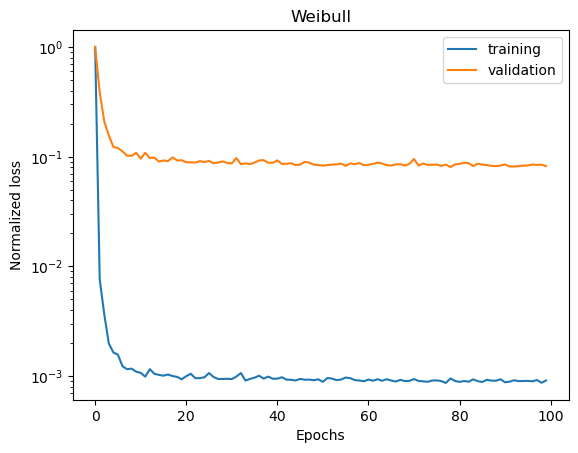

In [21]:
plot_losses(train_losses, val_losses, "Weibull")

### Section 2.3: Weibull AFT model evaluation

We evaluate the predictive performance of the model using 

* the [C-index](../_autosummary/torchsurv.metrics.cindex.html), which measures the the probability that a model correctly predicts which of two comparable samples will experience an event first based on their estimated risk scores,
* the [AUC](../_autosummary/torchsurv.metrics.auc.html), which measures the probability that a model correctly predicts which of two comparable samples will experience an event by time t based on their estimated risk scores, and
* the [Brier score](../_autosummary/torchsurv.metrics.brier_score.html), which measures the model's calibration by calculating the mean square error between the estimated survival function and the empirical (i.e., in-sample) event status.

We start by obtaining the subject-specific log hazard and survival probability at every time $t$ observed on the test set

In [22]:
weibull_model.eval()
with torch.no_grad():
    # event and time of length n
    x, (event, time) = next(iter(dataloader_test))
    log_params = weibull_model(x)  # shape = (n,2)

# Compute the log hazards from weibull log parameters
log_hz = weibull.log_hazard(log_params, time)  # shape = (n,n)

# Compute the survival probability from weibull log parameters
surv = weibull.survival_function(log_params, time)  # shape = (n,n)

We can evaluate the concordance index, its confidence interval and the p-value of the statistical test testing whether the c-index is greater than 0.5:

In [23]:
# Concordance index
weibull_cindex = ConcordanceIndex()
print("Weibull model performance:")
print(f"Concordance-index   = {weibull_cindex(log_hz, event, time)}")
print(f"Confidence interval = {weibull_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex >0.5
print(f"p-value             = {weibull_cindex.p_value(alternative='greater')}")

Weibull model performance:
Concordance-index   = 0.4542468786239624
Confidence interval = tensor([0.3055, 0.6030])
p-value             = 0.7266888618469238


For time-dependent prediction (e.g., 5-year mortality), the C-index is not a proper measure. Instead, it is recommended to use the AUC. The probability to correctly predicts which of two comparable patients will experience an event by 5-year based on their estimated risk scores is the AUC evaluated at 5-year (1825 days) obtained with

In [24]:
new_time = torch.tensor(1825.0)

# subject-specific log hazard at \5-yr
log_hz_t = weibull.log_hazard(log_params, new_time=new_time)  # shape = (n)
weibull_auc = Auc()

# auc evaluated at new time = 1825, 5 year
print(f"AUC 5-yr             = {weibull_auc(log_hz_t, event, time, new_time=new_time)}")
print(f"AUC 5-yr (conf int.) = {weibull_auc.confidence_interval()}")
print(f"AUC 5-yr (p value)   = {weibull_auc.p_value(alternative='greater')}")

AUC 5-yr             = tensor([0.4503])
AUC 5-yr (conf int.) = tensor([0.4014, 0.4992])
AUC 5-yr (p value)   = tensor([0.9767])


Lastly, we can evaluate the time-dependent Brier score and the integrated Brier score

In [25]:
brier_score = BrierScore()

# brier score at first 5 times
print(f"Brier score             = {brier_score(surv, event, time)[:5]}")
print(f"Brier score (conf int.) = {brier_score.confidence_interval()[:, :5]}")

# integrated brier score
print(f"Integrated Brier score  = {brier_score.integral()}")

Brier score             = tensor([0.4098, 0.4071, 0.4334, 0.4346, 0.4432])
Brier score (conf int.) = tensor([[0.4052, 0.3999, 0.4236, 0.4240, 0.4316],
        [0.4144, 0.4143, 0.4433, 0.4451, 0.4548]])
Integrated Brier score  = 0.24465881288051605


We can test whether the time-dependent Brier score is smaller than what would be expected if the survival model was not providing accurate predictions beyond random chance. We use a bootstrap permutation test and obtain the p-value with:

In [26]:
# H0: bs = bs0, Ha: bs < bs0; where bs0 is the expected brier score if the survival model was not providing accurate predictions beyond random chance.

# p-value for brier score at first 5 times
print(f"Brier score (p-val)        = {brier_score.p_value(alternative='less')[:5]}")

Brier score (p-val)        = tensor([0.5850, 0.6560, 0.4200, 0.2860, 0.5220])


## Section 3: Models comparison

We can compare the predictive performance of the Cox proportional hazards model against the Weibull AFT model.

### Section 3.1: Concordance index
The statistical test is formulated as follows, H0: cindex cox = cindex weibull, Ha: cindex cox > cindex weibull

In [27]:
print(f"Cox cindex     = {cox_cindex.cindex}")
print(f"Weibull cindex = {weibull_cindex.cindex}")
print(f"p-value        = {cox_cindex.compare(weibull_cindex)}")

Cox cindex     = 0.6594288945198059
Weibull cindex = 0.4542468786239624
p-value        = 0.015709560364484787


### Section 3.2: AUC at 5-year

The statistical test is formulated as follows, H0: 5-yr auc cox = 5-yr auc weibull, Ha: 5-yr auc cox > 5-yr auc weibull

In [28]:
print(f"Cox 5-yr AUC     = {cox_auc.auc}")
print(f"Weibull 5-yr AUC = {weibull_auc.auc}")
print(f"p-value          = {cox_auc.compare(weibull_auc)}")

Cox 5-yr AUC     = tensor([0.7149])
Weibull 5-yr AUC = tensor([0.4503])
p-value          = tensor([5.4292e-12])


## Section 4: Kaplan Meier


In [29]:
# Create a Kaplan-Meier estimator
km = KaplanMeierEstimator()

# Use our observed testing dataset
event = torch.tensor(df_test["cens"].values).bool()
time = torch.tensor(df_test["time"].values)

# Compute the estimator
km(event, time)

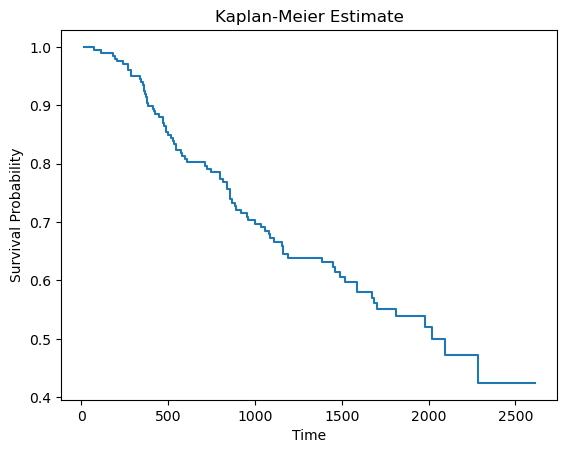

In [30]:
# plot estimate
km.plot_km()

In [31]:
# Print the survival values at each time step
km.get_survival_table()

Time	Survival
----------------
16.00	1.0000
17.00	1.0000
63.00	1.0000
72.00	0.9950
113.00	0.9901
168.00	0.9901
177.00	0.9901
184.00	0.9851
195.00	0.9801
205.00	0.9751
238.00	0.9701
272.00	0.9601
286.00	0.9551
288.00	0.9501
319.00	0.9501
322.00	0.9501
338.00	0.9450
343.00	0.9400
357.00	0.9349
359.00	0.9299
360.00	0.9248
370.00	0.9198
375.00	0.9147
377.00	0.9097
379.00	0.9046
385.00	0.8996
415.00	0.8945
420.00	0.8895
424.00	0.8895
426.00	0.8844
432.00	0.8844
448.00	0.8793
471.00	0.8741
473.00	0.8690
475.00	0.8639
490.00	0.8588
491.00	0.8537
500.00	0.8486
515.00	0.8435
530.00	0.8384
536.00	0.8332
545.00	0.8281
547.00	0.8230
553.00	0.8230
570.00	0.8230
573.00	0.8178
579.00	0.8127
596.00	0.8127
598.00	0.8075
612.00	0.8023
623.00	0.8023
628.00	0.8023
631.00	0.8023
651.00	0.8023
652.00	0.8023
663.00	0.8023
695.00	0.8023
712.00	0.7968
722.00	0.7913
723.00	0.7913
740.00	0.7913
741.00	0.7913
748.00	0.7857
768.00	0.7857
779.00	0.7857
797.00	0.7742
819.00	0.7685
825.00	0.7685
828.00	0.7685
838.00	

,Time,Survival
0,16.0,1.000000
1,17.0,1.000000
2,63.0,1.000000
3,72.0,0.995049
4,113.0,0.990099
...,...,...
189,2438.0,0.424474
190,2471.0,0.424474
191,2556.0,0.424474
192,2563.0,0.424474
